# COVID-19 Diagnosis Using CT Images
Developed by Luis Angeles

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import torch.nn as nn
import torch.nn.functional as nnF
import torch.optim as optim
import torchvision
import torchvision.models as tv_models
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io as io
import pandas as pd
from IPython import display
import time
import os
import copy

## Loading Data

In [ ]:
class MyDataset(torch_dataset):
    def __init__(self, path, filenamelist, labellist):
        # Initializing the variables for the dataset
        self.path = path
        self.filenamelist = filenamelist
        self.labellist = labellist
    
    def __len__(self):
        # Return the number of data points in the dataset
        return len(self.filenamelist)
    
    def __getitem__(self, idx):
        # Reading the image file
        I = io.imread(self.path + self.filenamelist[idx])
        # Convert the image to float32 and reshape it to (1, height, width)
        I = skimage.util.img_as_float32(I)
        I = I.reshape(1, I.shape[0], I.shape[1])
        # Convert the image to a tensor
        I = torch.tensor(I, dtype=torch.float32)
        # Expand the image tensor to (3, height, width)
        I = I.expand(3, I.shape[1], I.shape[2])
        # Convert the label to a tensor
        label = torch.tensor(self.labellist[idx], dtype = torch.int64)
        # Returns data point at a specific index
        return I, label

In [ ]:
# Load training dataset
def get_trainset():
    # Read the train.csv
    df_train = pd.read_csv('/content/gdrive/MyDrive/ML_COVID/S224/train.csv')

    # Set the path to the directory containing the images
    path = '/content/gdrive/MyDrive/ML_COVID/S224/'
    dataset_train = MyDataset(path, df_train['filename'].values, 
                              df_train['label'].values)
    
    return dataset_train

# Function to access the data in the provided dataset in batches
def get_trainloader():
    # Read the train.csv file using pandas
    df_train = pd.read_csv('/content/gdrive/MyDrive/ML_COVID/S224/train.csv')

    # Set the path to the directory containing the images
    path = '/content/gdrive/MyDrive/ML_COVID/S224/'
    dataset_train = MyDataset(path, df_train['filename'].values, 
                              df_train['label'].values)
    
    # Shuffle is set to True for training set
    loader_train = torch_dataloader(dataset_train, batch_size = 32, 
                                    num_workers = 0, shuffle = True)
    return loader_train

In [ ]:
# Same function as above but for validation set
def get_valset():
    df_val = pd.read_csv('/content/gdrive/MyDrive/ML_COVID/S224/val.csv')

    path = '/content/gdrive/MyDrive/ML_COVID/S224/'
    dataset_val = MyDataset(path, df_val['filename'].values, 
                              df_val['label'].values)
    
    return dataset_val

def get_valloader():
    df_val = pd.read_csv('/content/gdrive/MyDrive/ML_COVID/S224/val.csv')

    path = '/content/gdrive/MyDrive/ML_COVID/S224/'
    dataset_val = MyDataset(path, df_val['filename'].values, 
                              df_val['label'].values)
    
    # Shuffle is set to false for validation set
    loader_val = torch_dataloader(dataset_val, batch_size = 8, 
                                    num_workers = 0, shuffle = False)
    return loader_val

In [ ]:
# Repeat for test dataset
def get_testset():
    df_test = pd.read_csv('/content/gdrive/MyDrive/ML_COVID/S224/test.csv')

    path = '/content/gdrive/MyDrive/ML_COVID/S224/'
    dataset_test = MyDataset(path, df_test['filename'].values, 
                              df_test['label'].values)
    
    return dataset_test

def get_testloader():
    df_test = pd.read_csv('/content/gdrive/MyDrive/ML_COVID/S224/test.csv')

    path = '/content/gdrive/MyDrive/ML_COVID/S224/'
    dataset_test = MyDataset(path, df_test['filename'].values, 
                              df_test['label'].values)
    
    # For the test data set shuffle to false
    loader_test = torch_dataloader(dataset_test, batch_size = 32, 
                                    num_workers = 0, shuffle = False)
    return loader_test

In [ ]:
# Load datasets
dataset_train = get_trainset()
dataset_val = get_valset()
dataset_test = get_testset()

# Get dataloaders
loader_train = get_trainloader()
loader_val = get_valloader()
loader_test = get_testloader()

## Training a CNN from Scratch by Modifying Resnet50 for Binary Classification

In [8]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    # Loading Resnet50 as the base model
    self.resnet50 = tv_models.resnet50()
    # Change the final fully connected layer to only have one output for binary classification
    self.resnet50.fc = torch.nn.Linear(2048,1)
  
  def get_trainable_parameters(self):
    # These are the layers that are updated during training
    pList = (list(self.resnet50.layer4.parameters()) + 
             list(self.resnet50.fc.parameters()))
    return pList
  
  def forward(self, x):
    # Defines the computation performed by the network
    z = self.resnet50(x) # Passes input x through resnet50
    z = z.view(-1) # Flattens output tensor z to remove extra dimensions
    return z

In [9]:
# This function will save conditions about the model
def save_checkpoint(filename, model, optimizer, result, epoch):
  torch.save({'epoch': epoch, # current epoch
              'model_state_dict': model.state_dict(), # current state of model
              'optimizer_state_dict': optimizer.state_dict(),
              'result':result}, # model performance
             filename)
  print('saved:', filename)

### Define functions to train and test the model

Function to train the model over a single epoch

In [10]:
# Training the model over a single epoch
def train(model, device, optimizer, dataloader, epoch):    
  model.train() # Sets model to training mode
  loss_train = 0
  acc_train = 0  

  for batch_idx, (X, Y) in enumerate(dataloader): # Iterates over the data
    Y = Y.to(X.dtype) # Ensures the labels are the same dtype as inputs
    X, Y = X.to(device), Y.to(device) # Moves to specified device (e.g. GPU if available)
    optimizer.zero_grad() # Clears the gradient of each parameter
    Z = model(X) # Performs a forward pass
    loss = nnF.binary_cross_entropy_with_logits(Z, Y) # Computes binary cross entropy (loss function)
    loss.backward() # Performs a backward pass
    optimizer.step() # Updates model parameters
    loss_train += loss.item() # Accumalates loss and accuracy over the batch        
    Yp = (Z.data > 0).to(torch.int64) # Converts predicted logits to binary prediction
    Y = Y.to(torch.int64) # Converts true labels to binary labels
    acc_train += torch.sum(Yp==Y).item() # Records number of accurate predictions
    if batch_idx % 10 == 0: # Prints progress every 10 batches
      print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
          epoch, 100. * batch_idx / len(dataloader), loss.item()))

  # Computes average loss and accuracy over training set    
  loss_train /= len(dataloader)
  acc_train /= len(dataloader.dataset) 
  return loss_train, acc_train

Function to test the model

In [11]:
# The function will be similar to the training function but will use
# a confusion matrix to compute the sensitivity and precision of the model
def test(model, device, dataloader):
  model.eval() # Sets model to evaluation mode
  loss_test = 0
  acc_test = 0
  Confusion = np.zeros((2,2))

  with torch.no_grad(): # Tells PyTorch not to track gradients
    # Code below is same as training function
    for batch_idx, (X, Y) in enumerate(dataloader):
      Y = Y.to(X.dtype)
      X, Y = X.to(device), Y.to(device)
      Z = model(X)
      loss = nnF.binary_cross_entropy_with_logits(Z, Y)
      loss_test+=loss.item()
      Yp = (Z.data > 0).to(torch.int64)
      Y = Y.to(torch.int64)
      acc_test+= torch.sum(Yp==Y).item()

      # Updates the confusion matrix
      for i in range(0, 2):
        for j in range(0, 2):
          Confusion[i,j] += torch.sum((Y==i)&(Yp==j)).item()

  loss_test /= len(dataloader)        
  acc_test /= len(dataloader.dataset)

  # Initialize arrays to store sensitivity and precision
  Sensitivity = np.zeros(2)
  Precision = np.zeros(2) 

  # Computes sensitivity and precision  
  for n in range(0, 2):
    truePos = Confusion[n,n]
    falseNeg = np.sum(Confusion[n,:])-truePos
    falsePos = np.sum(Confusion[:,n])-truePos
    Sensitivity[n] = truePos/(truePos + falseNeg)
    Precision[n] = truePos/(truePos + falsePos)

  Acc = Confusion.diagonal().sum()/Confusion.sum() # Diagonal is correct predictions
  return loss_test, acc_test, (Confusion, Acc, Sensitivity, Precision)


## Creating a Model and Starting the Training-Validation Process

Set up model and initialize performance records

In [12]:
# Set up the model and have it run on GPU if available
#device = torch.device("mps") #M1 chip
#print('Device:', device)

model = Net() # creates model
#model.to(device) # moves model to sepcified device
optimizer = optim.SGD(model.parameters(), lr = 0.0001, momentum = 0.99) 

In [13]:
device = torch.device("cpu") # If other hardware is not supported

In [14]:
# Initializes lists to store training and validation results per epoch
loss_train_list = []
acc_train_list = []
loss_val_list = []
acc_val_list = []
epoch_save = -1

Training-Validation Process

In [15]:
# The function below is meant to visualize the training-validation results
def plot_result(loss_train_list, acc_train_list, 
                loss_val_list, acc_val_list):
  fig, ax = plt.subplots(1, 2, figsize = (12,6))
  ax[0].set_title('Loss vs Epoch', fontsize = 16)
  ax[0].plot(loss_train_list, '-b', label = 'Training Loss')
  ax[0].plot(loss_val_list, '-g', label = 'Validation Loss')
  ax[0].set_xlabel('Epoch', fontsize = 16)
  ax[0].legend(fontsize = 16)
  ax[0].grid(True)
  ax[1].set_title('Accuracy vs Epoch', fontsize = 16)
  ax[1].plot(acc_train_list, '-b', label = 'Training Accuracy')
  ax[1].plot(acc_val_list, '-g', label = 'Validation Accuracy')
  ax[1].set_xlabel('Epoch', fontsize = 16)
  ax[1].legend(fontsize = 16)
  ax[1].grid(True)
  return fig, ax

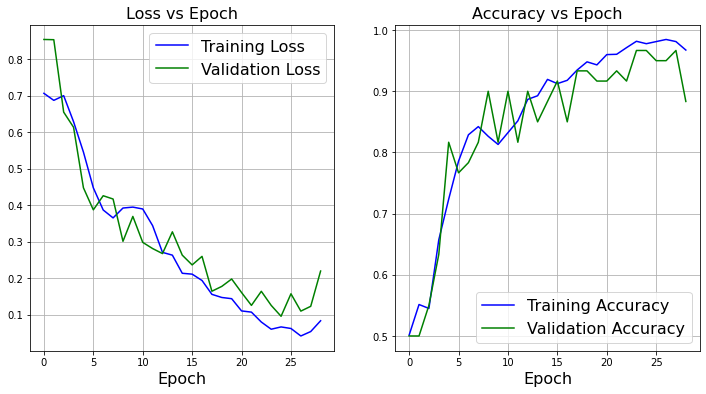

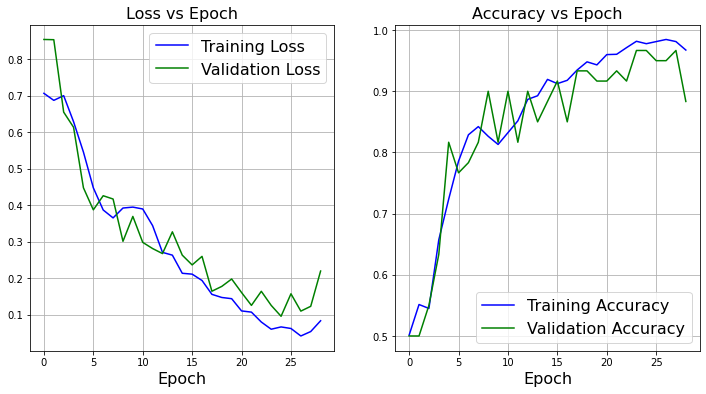

In [16]:
# Training-Validation Process Loop
for epoch in range(epoch_save+1, epoch_save+30):
  t0 = time.time() # Takes time at beginning of process

  #-------- training -----------------------------------------------------------
  loss_train, acc_train = train(model, device, optimizer, loader_train, epoch)    
  loss_train_list.append(loss_train)
  acc_train_list.append(acc_train)
  print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
  t1 = time.time()
  print("time cost", t1-t0) # Elapsed time for process to complete

  #-------- validation ---------------------------------------------------------
  loss_val, acc_val, other_val = test(model, device, loader_val)
  loss_val_list.append(loss_val)
  acc_val_list.append(acc_val)
  print('epoch', epoch, 'validation loss:', loss_val, 'acc:', acc_val)

  #-------- save model ---------------------------------------------------------
  result = (loss_train_list, acc_train_list, loss_val_list, 
            acc_val_list, other_val)
  save_checkpoint('CNN_LS_Pytorch_epoch'+str(epoch)+'.pt', 
                  model, optimizer, result, epoch) # Saves state to pytorch (pt) file
  epoch_save = epoch
  
  #------- show result ---------------------------------------------------------
  display.clear_output(wait = False)
  plt.close('all')
  fig, ax = plot_result(loss_train_list, acc_train_list, 
                        loss_val_list, acc_val_list)
  display.display(fig)

Load the best model and save the best model

In [17]:
best_id = np.argmax(acc_val_list) # Best model is one with the highest accuracy
epoch_save = best_id
checkpoint = torch.load('CNN_LS_Pytorch_epoch'+str(epoch_save)+'.pt', 
                        map_location=device) # Access saved model
model = Net()
model.load_state_dict(checkpoint['model_state_dict']) # Loads model
model.eval() # Evaluates model

(loss_train_list, acc_train_list, 
 loss_val_list, acc_val_list, other_val) = checkpoint['result']

In [18]:
# Evaluate model on test data
loss_test, acc_test, (Confusion, Acc, Sensitivity, Precision)=test(model, 
                                                                   device, 
                                                                   loader_test)
Confusion_sensitivity = Confusion.copy()
for n in range(0, 2):
    Confusion_sensitivity[n,:] /= np.sum(Confusion[n,:])
Confusion_precision = Confusion.copy()
for n in range(0, 2):
    Confusion_precision[:,n] /= np.sum(Confusion[:,n])

print('Accuracy (average)', acc_test)
print('Accuracy (average)', Acc)
print('Sensitivity', Sensitivity)
print('Precision', Precision)
print('Confusion_sensitivity \n', Confusion_sensitivity)
print('Confusion_precision \n', Confusion_precision)

<ipython-input-3-e8ed08bf7bec>:23: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(self.labellist[idx], dtype=torch.int64)


Accuracy (average) 0.935
Accuracy (average) 0.935
Sensitivity [0.93 0.94]
Precision [0.93939394 0.93069307]
Confusion_sensitivity 
 [[0.93 0.07]
 [0.06 0.94]]
Confusion_precision 
 [[0.93939394 0.06930693]
 [0.06060606 0.93069307]]


## Visualizing Model with GradCAM and EigenCAM

In [19]:
# both methods were taken from: https://github.com/jacobgil/pytorch-grad-cam

In [ ]:
!pip install grad-cam

In [21]:
from pytorch_grad_cam import GradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

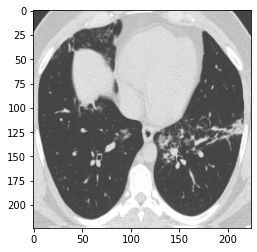

In [22]:
# Load a single rgb image from hard drive
image_gray = skimage.io.imread('/content/gdrive/MyDrive/ML_COVID/S224/COVID/Covid (62).png')
image_gray = image_gray.reshape(224,224,1)
image = np.concatenate([image_gray, image_gray, image_gray], axis=2)
image = image.astype("float32")
image = image/image.max()
plt.imshow(image)

In [24]:
# Convert numpy array to pytorch tensor
image_input = torch.tensor(image).permute(2,0,1) # (224,224,3) to (3,224,224)
image_input = image_input.reshape(1,3,224,224) # A batch that only has one image
image_input.shape

torch.Size([1, 3, 224, 224])

In [25]:
# Select the target layers from the model
target_layers = [model.resnet50.layer4[-1]]

In [30]:
class ClassifierOutputTarget:
  def __init__(self):
    pass
  def __call__(self, model_output):
    return model_output.sum()

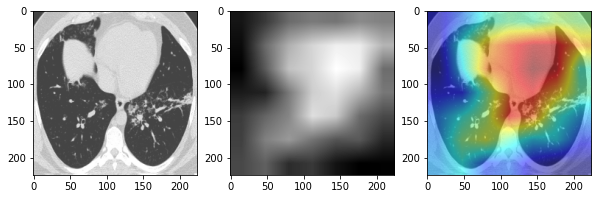

In [35]:
# Develop the CAM object
cam = GradCAM(model=model, target_layers=target_layers, use_cuda = False)
targets = [ClassifierOutputTarget()]
grayscale_cam = cam(input_tensor = image_input, targets = targets)
grayscale_cam = grayscale_cam[0]
cam_image = show_cam_on_image(image, grayscale_cam, use_rgb = True)
fig, ax = plt.subplots(1,3, figsize=(10, 10))
ax[0].imshow(image)
ax[1].imshow(grayscale_cam, cmap = 'gray')
ax[2].imshow(cam_image)

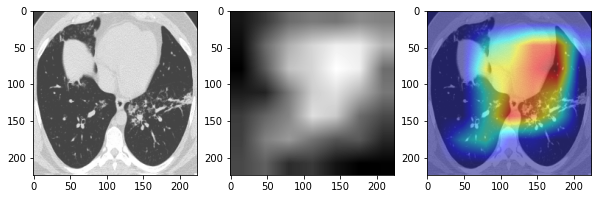

In [36]:
# Develop the EigenCAM object
eigcam = EigenCAM(model=model, target_layers=target_layers, use_cuda = False)
grayscale_cam2 = eigcam(input_tensor=image_input, targets = targets)
grayscale_cam2 = grayscale_cam2[0]
eigcam_image = show_cam_on_image(image, grayscale_cam2, use_rgb = True)
fig, ax = plt.subplots(1,3, figsize=(10, 10))
ax[0].imshow(image)
ax[1].imshow(grayscale_cam, cmap = 'gray')
ax[2].imshow(eigcam_image)